1. 利用二次规划函数，分别编程实现原问题求解的支撑向量机算法（Primal-SVM）、对偶的支撑向量机算法（Dual-SVM）、和核函数的支撑向量机算法（Kernel-SVM）。
2. 产生两个都具有200个二维向量的数据集X_1和X_2

[[ 1.         -5.11150699  1.53125874  1.        ]
 [ 1.         -5.49239359  0.02308329  1.        ]
 [ 1.         -6.4208252  -0.0937366   1.        ]
 ...
 [ 1.          0.35191359  2.65186188 -1.        ]
 [ 1.          0.03178338  4.61751432 -1.        ]
 [ 1.         -0.34530955  5.75484502 -1.        ]]

随机数据不分批次

SVM w:
 [ 4.41042762e-06 -2.31469744e-02 -2.34671786e-02]
SVM iteration: 100
SVM time: 2.8823115825653076


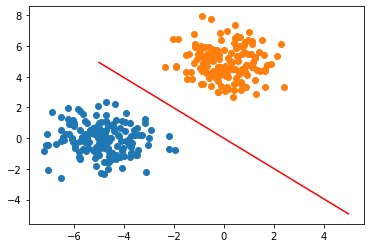

epoch-loss


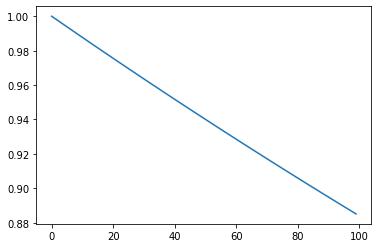


随机数据分1次一批

SVM w:
 [ 0.00548739 -0.32636712 -0.31815779]
SVM iteration: 100
SVM time: 4.171786069869995


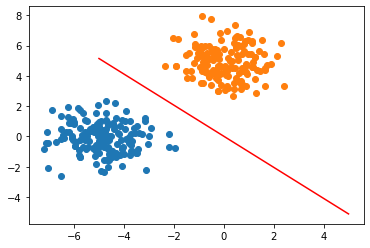

epoch-loss


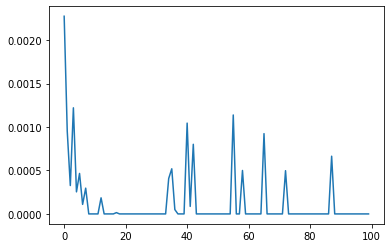


随机数据分1次一批，1000次迭代

SVM w:
 [ 0.02221878 -0.4375495  -0.42182734]
SVM iteration: 1000
SVM time: 41.1859073638916


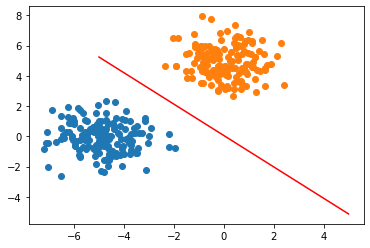

epoch-loss


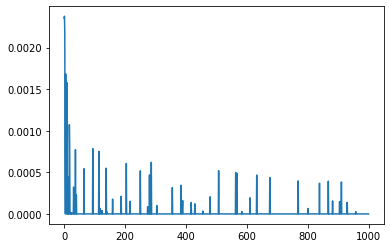


对偶问题

dual_SVM w:
 [ 1.66268856e-17 -4.09544788e-01 -4.97699303e-01]
dual_SVM time: 0.05009603500366211


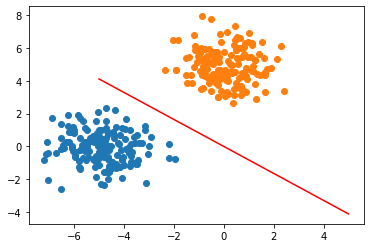


kernel SVM

kernel_SVM w:
 [[-0.04273865]
 [-0.05708955]
 [ 0.07180901]
 [ 0.00172535]
 [-0.11861093]]
kernel_SVM time: 0.04410576820373535


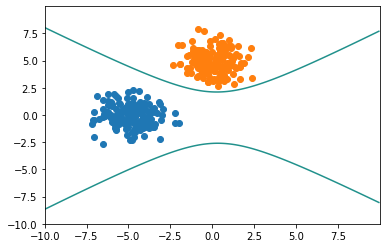

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import math
import torch
import cvxopt
from cvxopt import matrix, solvers 
import pandas as pd

X1 = np.random.multivariate_normal((-5,0), [[1,0],[0,1]], (200,), 'ignore') #二维正态分布

X2 = np.random.multivariate_normal((0,5), [[1,0],[0,1]], (200,), 'ignore')


X1_train = X1[:-40]
X1_test = X1[-40:]
X2_train = X2[:-40]
X2_test = X2[-40:]

X1_train = np.array(X1_train)
X1_test = np.array(X1_test)
X2_train = np.array(X2_train)
X2_test = np.array(X2_test)


data_SVM_train = np.vstack((np.c_[np.ones(len(X1_train)),X1_train,np.ones(len(X1_train))],\
            np.c_[np.ones(len(X2_train)),X2_train,[-1] * len(X2_train)]))   #合并数据

data_SVM_test = np.vstack((np.c_[np.ones(len(X1_test)),X1_test,np.ones(len(X1_test))],\
            np.c_[np.ones(len(X2_test)),X2_test,[-1] * len(X2_test)]))

print(data_SVM_train)
def list_split(items, n):
  return [items[i:i+n] for i in range(0, len(items), n)]


def SVM(batch_size = len(data_SVM_train), max_count = 100, rate = 0.0001):
  start = time.time()

  data = np.array(data_SVM_train)
  X = np.mat(data[:,:-1])
  Y = np.transpose(np.mat(data[:,-1]))
  count = 0
  w = np.transpose(np.mat([.0,.0,.0]))
  list_loss = []
  while count < max_count:
    data = np.array(data_SVM_train)
    np.random.shuffle(data)     #随机数据
    batch_data = np.array(list_split(data, batch_size))   #根据batch_size分批
    flag = 0
    for i in range(0, len(batch_data)):
      X = np.mat(batch_data[i][:,:-1])
      Y = np.transpose(np.mat(batch_data[i][:,-1]))
      grad = 0
      loss = 0
      loss_sum = 0
      for i in range(0,len(X)):
        loss += max(0, 1 - (Y[i][0,0] * np.transpose(w) * np.transpose(X[i]))[0,0])
        grad += max(0, 1 - (Y[i][0,0] * np.transpose(w) * np.transpose(X[i]))[0,0]) * (-Y[i][0,0] * np.transpose(X[i]))
      loss_sum += loss
      loss /= len(X)
      grad /= len(X)
      w -= rate * grad
    loss_sum /= len(data)
    list_loss.append([count, loss_sum])
    count += 1


  end = time.time()

  data = np.array(data_SVM_train)
  X = np.mat(data[:,:-1])
  Y = np.transpose(np.mat(data[:,-1]))

  w = np.array(np.transpose(w)).reshape(3)  #变更格式

  print("\nSVM w:\n",w)
  print("SVM iteration:",count)
  print("SVM time:",end - start)

  X = data[:,:-1]
  plot_x = np.linspace(-5,5,1000)
  plot_y = -(w[1]/w[2])*plot_x - w[0]/w[2]
  plt.plot(plot_x, plot_y, 'r')
  plt.scatter(X1_train[:,0], X1_train[:,1])
  plt.scatter(X2_train[:,0], X2_train[:,1])
  plt.show()

  list_loss = np.array(list_loss)
  print("epoch-loss")
  plt.plot(list_loss[:,0],list_loss[:,1])
  plt.show()


  return w
#####################################################################################
def dual_SVM():       #对偶问题
  start = time.time()
  data = np.array(data_SVM_train)
  X = np.array(data[:,:-1])
  y = np.array(data[:,-1])
  N = X.shape[0]
  temp = y.reshape(-1, 1) * X
  Q = matrix(np.dot(temp, temp.T).astype(np.double))
  p = matrix(-np.ones(N))
  G = matrix(-np.eye(N)[range(0, N)])
  h = matrix(np.zeros(N))
  A = matrix(y.astype(np.double), (1, N))
  b = matrix(0.0)

  sol = solvers.qp(Q, p, G, h, A, b)
  alpha = np.array(sol['x']).reshape(-1)
  w = np.dot(alpha * y, X)
  non_zero_index = np.where(np.abs(alpha) > 1e-6)[0][0]
  b = y[non_zero_index] - np.dot(w, X[non_zero_index])
  end = time.time()
  print("\ndual_SVM w:\n",w)
  print("dual_SVM time:",end - start)


  X = data[:,:-1]
  plot_x = np.linspace(-5,5,1000)
  plot_y = -(w[1]/w[2])*plot_x - w[0]/w[2]
  plt.plot(plot_x, plot_y, 'r')
  plt.scatter(X1_train[:,0], X1_train[:,1])
  plt.scatter(X2_train[:,0], X2_train[:,1])
  plt.show()

  
  return w
###########################################################################################

def kernel(X1, X2):
  x1 = matrix([1, X1[1], X1[2]])
  x2 = matrix([1, X2[1], X2[2]])
  return (x1.T * x2 + (x1.T * x2) * (x1.T * x2))[0, 0]

def get_z(x):
  return matrix([x[1], x[2], x[1] * x[1], x[1] * x[2], x[2] * x[2]])

def kernel_SVM():
  N = len(data_SVM_train)
  Q = np.mat(np.arange(N))
  for i in range(N):
    q = []
    for j in range(N):
      q.append(data_SVM_train[i][3] * data_SVM_train[i][3] * kernel(data_SVM_train[i], data_SVM_train[j]))  
    Q = np.r_[Q, np.mat(q)]
  Q_array = np.array(Q)
  Q = matrix(Q_array[1:][:])

  p = []
  for i in range(N):
    p.append(-1.0)
  p = matrix(p)
 
  A = np.zeros((N, N))
  A_array = np.array(A)
  for i in range(N):
    A_array[i][i] = -1.0
  A = matrix(A_array)
  
  c = matrix(np.zeros((1, N)).T)

  r_list = []
  for t in data_SVM_train:
    r_list.append(float(t[3]))
  r = matrix(r_list).T

  v = matrix(0.0)

  solvers.options['show_progress'] = False
  start = time.time()
  sol = solvers.qp(Q, p, A, c, r, v)
  alpha = sol['x']
  w = matrix([0.0, 0.0, 0.0, 0.0, 0.0])
  for i in range(N):
    if alpha[i, 0] > 1e-6:
      w = w + alpha[i] * data_SVM_train[i][3] * get_z(data_SVM_train[i])
  b = 0
  for i in range(N):
    if alpha[i, 0] > 1e-6:
      z = get_z(data_SVM_train[i])
      b = data_SVM_train[i][3]
      for j in range(5):
         b = b - w[j] * z[j]
      break
  end = time.time()
  print("\nkernel_SVM w:\n",w)
  print("kernel_SVM time:",end - start)


  plt.scatter(X1_train[:,0], X1_train[:,1])
  plt.scatter(X2_train[:,0], X2_train[:,1])

  x = np.arange(-10, 10, 0.01)
  y = np.arange(-10, 10, 0.01)
  # 转化为网格
  x, y = np.meshgrid(x, y)
  z = b + x * w[0, 0] + y * w[1, 0] + np.power(x, 2) * w[2, 0] + x * y * w[3, 0] + np.power(y, 2) * w[4, 0]
  plt.contour(x, y, z, 0)
  plt.show()


  return w



print("\n随机数据不分批次")
w = SVM()
print("\n随机数据分1次一批")
w = SVM(1)
print("\n随机数据分1次一批，1000次迭代")
w = SVM(1, 1000)
print("\n对偶问题")
w = dual_SVM()
print("\nkernel SVM")
w = kernel_SVM()